# Music genre classification

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# Misc
import os, sys
from glob import glob

In [3]:
import random

In [4]:
# Dataframes and such
import pandas as pd
import numpy as np

In [5]:
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Ipython stuff
import IPython
import IPython.display as ipd

In [7]:
# Audio stuff
import librosa
import librosa.display

In [8]:
from tqdm.notebook import tqdm

In [9]:
# This must point to the root folder of the GTZAN dataset (the folder containing all genres subfolders)
DATA_FOLDER = "../data/gtzan"

## Table of contents

* [Introduction and project description](#Introduction-and-project-description)
* [Dataset](#Dataset)
* Data augmentation
* Model training
* Results
* Future works

## Introduction and project description

The goal of the project is pretty straightforward: train a Machine Learning model able to classify an audio clip as one of ten possible genres, using the GTZAN dataset.

I chose to focus on the first question, i.e. "Make a good model".

### Project organization

Having a little more than a weekend at my disposal, I organized the work identifying the following tasks, here listed in the rough order in which I did them:

 1. Base exploratory data analysis; 
 1. Setting up dataset transformations (creating mel spectrograms);
 1. Setting up pipeline for creating augmentations;
 1. Model training, iteration on models/hyperparameters;
 1. Writing report and documentation.
 
I estimated ~40% of the time to be dedicated to the first 3 tasks (mostly because this required me to write custom code that I didn't have available, so I wanted to keep margin for error), ~40% of the time for training models (simply because I expected long-ish training times due to the experiment setup, more on that in a later Section) and the remaining ~20% of the time for writing the report and going one final time through the code to improve its quality/readability.

Some of the code used in this assignment was already available from past experimentations with the dataset, other pieces were cannibalized from code I used a while ago to keep track of experiments using [Sacred](https://github.com/IDSIA/sacred).

### Cutting some corners

Due to time constraints, some decisions had to be made before starting to work, to try to avoid dangerous time-consuming pitfalls:

 * use known architectures: I avoided trying anything "too exotic" to avoid wasting time trying to fix bugs in something that at best could give me a **hardly defendable** (more on this in the **Dataset** Section) 0.3% increase in accuracy;
 * spend a limited amount of time exploring different architectures: my feeling is that for this specific dataset and using a CNN-based approach, unless significantly more time is spent researching an architecture that can provide the best possible representation of the input data, any _reasonable_ choice for a network would work for my purposes. Again, more on this in the next Section;
 * prioritize "small" models: given the limited amount of available data, I only considered "small" version of common architectures, mainly to speed up the iteration process;
 * manage expectations: spend some time trying to get a grasp of what kind of results (in terms of classification accuracy) I could hope to achieve, to avoid wasting time overfitting noise. More details on this in the following section.
 
These however are all choices that, in the worst case scenario, _limit_ the accuracy achieved. The way I chose to evaluate the performances, i.e. K-fold cross validation without a proper separate validation subset for hyperparameter optimization, potentially leads to _slightly_ positively biased results, albeit I considered the effect of this to be very limited, and (as long as acknowledged) acceptable in this scenario. I will address this in more detail in a later Section.

[Back to top](#Table-of-contents)

## Dataset

The dataset is the GTZAN Genre Collection dataset from

>Tzanetakis, George, and Perry Cook. "Musical genre classification of audio signals." IEEE Transactions on speech and audio processing 10.5 (2002): 293-302.

It consists of a total of 1000 audio clips in .wav format, sampled at 22050 Hz 16 bits, divided in 10 groups, one for each of the ten music genres included in this dataset: blues, classical, country, disco, hiphop, jazz, metal, pop, reggae and rock. Each group is represented by 100 samples, and each sample is 30s long.

The dataset also includes the mel spectrograms generated for each of the audio clips included, in the form of RGBA images, to facilitate experimentation using CNNs.

### General considerations

I would like to take some time to discuss some crucial aspects of the task at hand that have to do with the nature of the data, and specifically with the way it has been annotated, what it implies, and how it affects the project.
I'm referring specifically to the fact that each one of the 1000 samples has been annotated with exactly **one** label, defining its genre, which makes the choice of a single-label classification approach the most natural.

There are however, in my opinion, some issues with this, some of which are addressed in more detail in a [report](https://arxiv.org/abs/1306.1461) referenced in the assignment's description. My main problem with the framing described above is that, unlike some other tasks such as the extremely popular digits recognition using the MNIST dataset, there is not a precise definition (or at least one which is quantifiable enough) of what characteristics a song should have to be considered of a certain genre. This is due to the nature and the evolution of music: genres evolved from one another, and there are a lot of cases where it is ultimately quite subjective whether a song is rock, blues metal or pop. This effectively translates in an objective difficulty in the assignment of a genre to a song in some cases.

Moreover, it is not uncommon for songs to have sections that, if taken out of context, could very well sound as belonging to a different genres: the classical parts in modern power metal songs (e.g. Stratovarius), or rock ballads that have a more "pop" feel (see as an example file `rock.00049.wav`).

My point is, I believe that a single-label annotation fails to capture the complexity of this type of data, and this should be taken into account both in the experiment design and in the evaluation.

Other issues reported in the paper linked above highlight other issues, such as

* high variability in audio quality in samples;
* heavy artist repetition, which leads to not-really-i.i.d. dataset;
* actual mislabeling of some samples.

tl;dr, I believe there is an upper bound to the achievable accuracy, and getting a model with extremely high accuracy is not only unlikely, but would be suspicious.

### Expectation management

When starting a project such as this one, I like to get a sense of what kind of performances I can expect (and, also important, what NOT to expect), given the data available and the nature of the task.
After a quick google search, 

Specifically, [Papers With Code](https://paperswithcode.com/sota/music-genre-classification-on-gtzan) reports an accuracy of 83.9% on this exact task. I skimmed through the actual paper used to produce that result but couldn't find an actual description of exactly _how_ that number was obtained, as in what set it was tested on. Anyway I considered that to be an overall reasonable reference for the _range_ of accuracy that I could achieve. 
Other papers report significantly higher results ([87.4%](https://www.isca-speech.org/archive_v0/Interspeech_2016/pdfs/1236.PDF), [93.65%](https://www.mdpi.com/2079-9292/10/18/2206#:~:text=The%20best%20classification%20accuracy%20on,superior%20to%20most%20current%20methods.)), but having only skimmed through abstracts I don't know how the performances were evaluated (and in general I'm quite suspicious about the second one, given the considerations from the previous section).

tl;dr If I achieve somewhat around 80% accuracy I'll be more than happy.

### Checking the data

Due to the nature of the data (the fact that they are audio files), to get an idea of the samples available in GTZAN I simply listened to a few random audio files from different genres.

Since this was a well-known benchmark dataset, I didn't really need to check other things like labels distribution, sample duration or sampling rates.

In [12]:
# Make a list of all the wav files in the dataset and store them in a variable
audio_files = glob(f"{DATA_FOLDER}/*/*.wav")

In [13]:
random_file = random.choice(audio_files)
print(f"Showing random file {os.path.basename(random_file)}")
ipd.Audio(random_file)

Showing random file rock.00049.wav


In [14]:
# Load audio file with librosa
y, sr = librosa.load(random_file)

print(f"y is a {type(y)}, sr is a {type(sr)}")
print(f"First 10 elements of y: {y[:10]}")
print(f"Shape of Y: {y.shape}")
print(f"Sample Rate: {sr}")

y is a <class 'numpy.ndarray'>, sr is a <class 'int'>
First 10 elements of y: [0.01974487 0.0213623  0.0222168  0.02243042 0.02301025 0.02584839
 0.02642822 0.03018188 0.03201294 0.0324707 ]
Shape of Y: (661794,)
Sample Rate: 22050


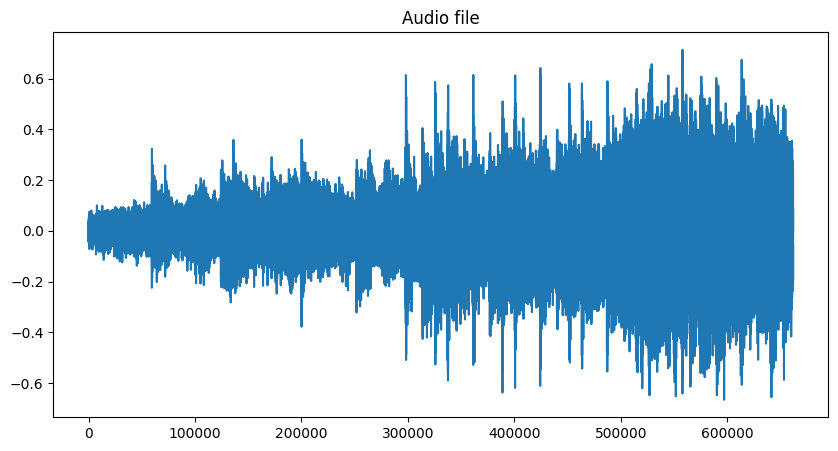

In [15]:
# Plot the actual wave
plt.figure(figsize=(16, 8))
pd.Series(y).plot(figsize=(10, 5), title="Audio file");

The only thing I noticed (I actually noticed this later during data transformation, but it fits better in this Section) is that one of the files appears to be corrupted in some way (file `jazz.00054.wav`), and thus has been removed from the dataset. I assumed removing one file out of 1000 only would not really impact significantly the results of the experiments.

### MEL Spectrograms

One common approache to analyze audio data is to generate **Mel Spectrograms** from the audio samples. Without getting too much into detail on the nature of these spectrograms, which is beyond the point of this report, Mel spectrograms provide a representation of an audio clip as a 2D array, the x axis representing **time** and the y axis representing **frequency bins in the Mel scale**.

The peculiarity of the Mel scale is that it provides a representation of frequencies such that it resembles the way that we humans perceive it (as we happen to not be great at appreciating differences in a linear scale), meaning that differences in "color" (intensity) in the Mel spectrogram better represent differences in frequency/pitch than if we were using a linear scale.

| ![If you're seeing this text, your internet died](https://www.sfu.ca/sonic-studio-webdav/handbook/Graphics/Mel.gif) |
|:--:|
| Image from [Simon Fraser University](https://www.sfu.ca/sonic-studio-webdav/handbook/Mel.html) |

For more information about Mel spectrograms, I found [this](http://gipsy-danger:8888/notebooks/notebooks/Report.ipynb#Music-genre-classification) article on Medium to give a nice explanation on the subject.

The `librosa` package provides functions to generate Mel spectrograms from an audio clip. These functions accept several parameters that change how the underlying Short-Time Fourier Transform is computed on the original signal, and the number of Mel bands generated.

For our purposes (and because I didn't really know how to do better than that), I kept the default values for these parameters (in the following cell).

In [16]:
hop_length = 512
n_fft = 2048
n_mels = 256

In [17]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, n_mels=n_mels, hop_length=hop_length)
print("Shape of Mel Spectogram", S.shape)

# use that converting function as above
S_db_mel = librosa.amplitude_to_db(S, ref=np.max)

Shape of Mel Spectogram (256, 1293)


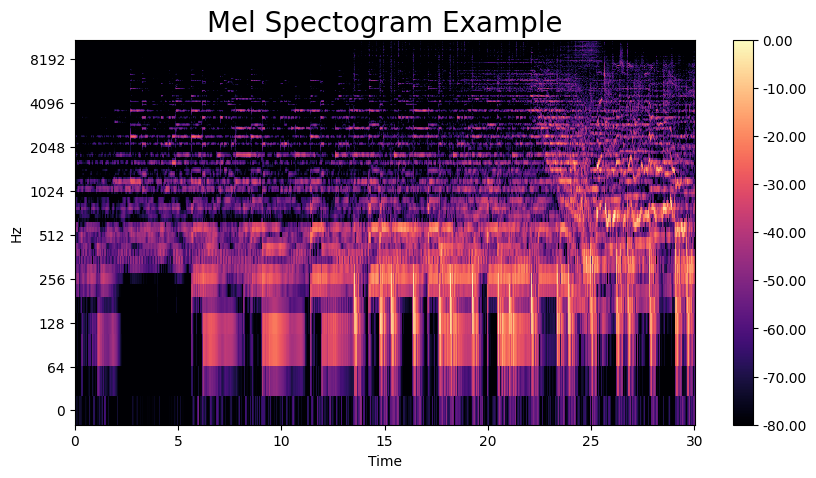

In [18]:
# plot the mel spectogram
fig, ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(S_db_mel, x_axis='time', y_axis='log', ax=ax)
ax.set_title('Mel Spectogram', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f');

One thing to note is that while the above plot of the Mel spectrogram is colored, as it uses the default color map often used for this type of spectrograms in order to make it more readable, the spectrogram itself is a 2D array of shape `(n_mels, T)`, where `T` is proportional to the duration of the original audio clip.

This will require some hacking when setting up the training pipeline, but we'll get to that in a later section.

As a final note, the GTZAN dataset I downloaded also included pre-computed spectrograms, however we're not going to use those for several reasons:

* we're planning to do data augmentation on the dataset, adding audio effects to the original signal **before** computing the spectrograms, therefore I wouldn't be able to use them anyway;
* those are RGBA images, since they have probably been exported from a plot such as the one generated above. however, as stated previously, the actual spectrograms are 2D arrays, which means that all the _information_ is contained in one channel only (as opposed to 3 or 4 for colored RGB/RGBA images). There is no reason to use the colored version, I'm guessing those are included to facilitate the use of this dataset off the shelf with traditional CNNs, that usually are designed to receive in input RGB images;
* this is personal, but it bothers me that they have a white padding.

[Back to top](#Table-of-contents)

## Experimental setup

I decided to choose the experimental setup based on how I would later assess the performance of the trained model[s] and the resources at my disposal, in terms of time and available hardware for training.

Ideally, I would have split the dataset in 10 equal splits and then ran 10 sets of experiments where one fold would have been kept as the test set for final evaluation and the remaining 9 folds used for training and hyperparameter optimization (probably using 8 folds for training and one for validation). This however would have taken quite a lot of time, especially when training a model on an augmented version of the dataset, so I ended up opting for a potentially more biased but (in my opinion) acceptable compromise: I split the dataset in only 5 folds, each containing 20% of the data, and for each fold used the remaining 80% for training. Therefore, I didn't have a proper separate test set, as I was using the one fold for each iteration as validation set to assess the performance. I (hopefully) mitigated the bias by experimenting with hyperparameters on only one subdivision (the one using `fold_0` as validation/test set) and then using the same values for all splits.

### Hyperparameter search

The only hyperparameter I ended up tweaking was the learning rate of the optimizer, as I didn't feel like the others (`gamma` parameter for learning rate scheduler or batch size) impacted significantly on the results.

Moreover, having chosen to use a pre-built architecture, I didn't really have a lot of [easily accessible] control over some of the internal parameters used, aside from the dropout, which I chose not to touch.

The decision not to play around too much with hyperparameters was also heavily influenced by the fact that already early experiments produced results with pretty good metrics around the optimistic values that I was aiming at, and at that point I didn't think it would have made sense trying to improve on those, for the reasons explained in the [Dataset](#Dataset) Section.

I used [Sacred](https://github.com/IDSIA/sacred) for tracking experiments and passing parameters to the main training script, and [Omniboard](https://github.com/vivekratnavel/omniboard) as a visualization tool. 
The MongoDB required to store experiments logs and the actual instance of omniboard were running on the same machine running the experiments, using the `docker-compose.yml` file (with one small modification to enable volume persistence, so that I wouldn't lose data in case the VM died) included in the root folder of the repository.
The training command was saved in a shell script, so that it could be executed with just one command from the terminal `./train_command.sh`.

| ![If you're seeing this text, your internet died](sacred_screenshot.png) |
|:--:|
| A screenshot of the Omniboard instance used to keep track of experiments |

[Back to top](#Table-of-contents)

In [19]:
1/0

ZeroDivisionError: division by zero

## Data augmentation

#### XXX Pitch shift, time stretch and noise addition

#### XXX Doing on the fly augmentations

#### XXX Data was split BEFORE doing augmentations, to prevent leakage

#### XXX Adding reverb?

## Modeling

## Training

#### XXX Focal loss

https://arxiv.org/pdf/1708.02002.pdf

#### XXX Sacred for experiment tracking

#### XXX Why is training loss higher than val loss

#### XXX Loss curves

## Results

#### XXX Model evaluation

## Deployment

## Future works

## TL;DR

XXX

[Back to top](#Table-of-contents)

[Back to top](#Table-of-contents)

## Misc


* Python packages were managed using `poetry`; instructions on how to install `poetry` and setup the virtual environment required to train and evaluate the model are included in the `README.md` file in the root of this repository
* Experiments were performed on a VM hosted on GCP mounting one Nvidia T4
* Driver info from `nvidia-smi`: `NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0`

[Back to top](#Table-of-contents)